#Importing

In [1]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip3 install pandas-profiling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
!pip install markupsafe==2.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML
display()
from google.colab import drive
drive.mount('/content/gdrive')
from pandas_profiling import ProfileReport
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC, SVR

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Reading data

In [5]:
train_reg_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/ML_Assignments_Data/1st_Assignment/bitrate_prediction_Reg/bitrate_train.csv')
test_reg_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/ML_Assignments_Data/1st_Assignment/bitrate_prediction_Reg/bitrate_test.csv')
train_class_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/ML_Assignments_Data/1st_Assignment/stream_quality_data_Class/train_data.csv')
test_class_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/ML_Assignments_Data/1st_Assignment/stream_quality_data_Class/test_data.csv')

In [6]:
train_reg_df.columns==test_reg_df.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [7]:
test_class_df.columns==train_class_df.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

#Profiling

In [8]:
#report = ProfileReport(train_reg_df)
#report

In [9]:
#report = ProfileReport(test_reg_df)
#report

In [10]:
# Drop these columns because they are hints for prediction
train_reg_df = train_reg_df.drop(columns=['bitrate_std', 'bitrate_mean'], axis=1)
test_reg_df = test_reg_df.drop(columns=['bitrate_std', 'bitrate_mean'], axis=1)
# Drop these columns because they have more than 97% zeros in both train and test datasets
train_reg_df = train_reg_df.drop(columns=['dropped_frames_mean', 'dropped_frames_std', 'dropped_frames_max'], axis=1)
test_reg_df = test_reg_df.drop(columns=['dropped_frames_mean', 'dropped_frames_std', 'dropped_frames_max'], axis=1)


In [11]:
#report = ProfileReport(train_class_df)
#report

In [12]:
#report = ProfileReport(test_class_df)
#report

In [13]:
# Drop these columns because they have more than 90% zeros in both train and test datasets
train_class_df = train_class_df.drop(columns=['dropped_frames_mean', 'dropped_frames_std', 'dropped_frames_max', 'fps_lags'], axis=1)
test_class_df = test_class_df.drop(columns=['dropped_frames_mean', 'dropped_frames_std', 'dropped_frames_max', 'fps_lags'], axis=1)


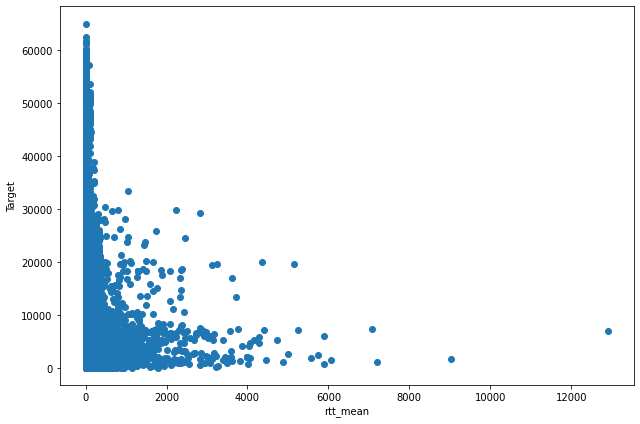

In [14]:
plt.figure(figsize=(9, 6))
plt.scatter(train_reg_df['rtt_mean'], train_reg_df['target'])
plt.xlabel('rtt_mean')
plt.ylabel('Target')
plt.tight_layout()
plt.show()

#Encoding

In [15]:
train_reg_df.dtypes

fps_mean    float64
fps_std     float64
rtt_mean    float64
rtt_std     float64
target      float64
dtype: object

In [16]:
test_reg_df.dtypes

fps_mean    float64
fps_std     float64
rtt_mean    float64
rtt_std     float64
target      float64
dtype: object

In [17]:
train_class_df.dtypes

fps_mean              float64
fps_std               float64
rtt_mean              float64
rtt_std               float64
auto_bitrate_state     object
auto_fec_state         object
auto_fec_mean         float64
stream_quality          int64
dtype: object

In [18]:
test_class_df.dtypes

fps_mean              float64
fps_std               float64
rtt_mean              float64
rtt_std               float64
auto_bitrate_state     object
auto_fec_state         object
auto_fec_mean         float64
stream_quality          int64
dtype: object

In [19]:
# Lets encode object columns. In regression there arent any, but classification has.
obj_col = train_class_df.select_dtypes(include=['object']).columns.tolist()
encoder = OneHotEncoder(obj_col, handle_unknown='ignore')
encoder.fit(train_class_df)
test_class_encoded = encoder.transform(test_class_df)
train_class_encoded = encoder.transform(train_class_df)

In [20]:
class_cols = train_class_encoded.columns
reg_cols = train_reg_df.columns

#Imputing

In [21]:
test_reg_df.isna().sum()

fps_mean    0
fps_std     0
rtt_mean    0
rtt_std     0
target      0
dtype: int64

In [22]:
train_reg_df.isna().sum()

fps_mean    0
fps_std     0
rtt_mean    0
rtt_std     0
target      0
dtype: int64

In [23]:
test_class_df.isna().sum()

fps_mean              0
fps_std               0
rtt_mean              0
rtt_std               0
auto_bitrate_state    0
auto_fec_state        0
auto_fec_mean         0
stream_quality        0
dtype: int64

In [24]:
train_class_df.isna().sum()

fps_mean              0
fps_std               0
rtt_mean              0
rtt_std               0
auto_bitrate_state    0
auto_fec_state        0
auto_fec_mean         0
stream_quality        0
dtype: int64

We have no NaN values in our datasets

#Splitting

In [25]:
train_reg_Y = train_reg_df['target']
train_reg_X = train_reg_df.drop('target', axis=1)
test_reg_Y = test_reg_df['target']
test_reg_X = test_reg_df.drop('target', axis=1)
reg_cols = train_reg_X.columns

train_class_Y = train_class_encoded['stream_quality']
train_class_X = train_class_encoded.drop('stream_quality', axis=1)
test_class_Y = test_class_encoded['stream_quality']
test_class_X = test_class_encoded.drop('stream_quality', axis=1)
class_cols = train_class_X.columns

#Scaling

In [26]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

fit_reg = scaler.fit(train_reg_X)

train_reg_X = pd.DataFrame(scaler.transform(train_reg_X), columns=reg_cols)
test_reg_X = pd.DataFrame(scaler.transform(test_reg_X), columns=reg_cols)

fit_class = scaler.fit(train_class_X)

train_class_X = pd.DataFrame(scaler.transform(train_class_X), columns=class_cols)
test_class_X = pd.DataFrame(scaler.transform(test_class_X), columns=class_cols)

#Learning 1

In [42]:
from sklearn.metrics import mean_squared_error
def reg_models(X_train, y_train, X_test, y_test):
  alphas = [2.2, 2, 1.5, 1.3, 1.2, 1.1, 1, 0.3, 0.1]
  losses = []
  for alpha in alphas:
      # Write (4 lines): create a Lasso regressor with the alpha value.
      # Fit it to the training set, then get the prediction of the validation set (x_val).
      # calculate the mean squared error loss, then append it to the losses array
      y_pred = Lasso(alpha=alpha).fit(X_train, y_train).predict(X_test)
      mse = mean_squared_error(y_test,y_pred)
      losses.append(mse)
  plt.plot(alphas, losses)
  plt.title("Lasso alpha value selection")
  plt.xlabel("alpha")
  plt.ylabel("Mean squared error")
  plt.show()

  lasso_best_alpha = alphas[np.argmin(losses)]
  print("Best value of lasso alpha:", lasso_best_alpha)
  print('------------------------------------------\n')

  losses = []
  for alpha in alphas:
      # Write (4 lines): create a Lasso regressor with the alpha value.
      # Fit it to the training set, then get the prediction of the validation set (x_val).
      # calculate the mean squared error loss, then append it to the losses array
      y_pred = Ridge(alpha=alpha).fit(X_train, y_train).predict(X_test)
      mse = mean_squared_error(y_test,y_pred)
      losses.append(mse)
  plt.plot(alphas, losses)
  plt.title("Lasso alpha value selection")
  plt.xlabel("alpha")
  plt.ylabel("Mean squared error")
  plt.show()

  ridge_best_alpha = alphas[np.argmin(losses)]
  print("Best value of ridge alpha:", ridge_best_alpha)
  print('-----------------------------------------\n')

  lin = LinearRegression()
  lin.fit(X_train, y_train)
  y_pred = lin.predict(X_test)
  print('Linear Regression:')
  print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
  print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
  print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
  print('--------------------------------------------------------\n')

  poly_reg = PolynomialFeatures(degree=2)
  X_poly = poly_reg.fit_transform(X_train)
  pol_reg = LinearRegression()
  pol_reg.fit(X_poly, y_train)
  y_pred = pol_reg.predict(poly_reg.fit_transform(X_test))
  print('Polynomical Regression:')
  print('Mean Absolute Error:', metrics.mean_absolute_error(test_reg_Y, y_pred))
  print('Mean Squared Error:', metrics.mean_squared_error(test_reg_Y, y_pred))
  print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_reg_Y, y_pred)))
  print('--------------------------------------------------------\n')

  # log = LogisticRegression(random_state=0)
  # log.fit(X_train, y_train)
  # y_pred = log.predict(X_test)
  # print('Logistic Regression:')
  # print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
  # print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
  # print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
  # print('--------------------------------------------------------\n')


  las = Lasso(alpha=lasso_best_alpha)
  las.fit(X_train, y_train)
  y_pred = las.predict(X_test)
  print('Lasso with alpha = ', lasso_best_alpha)
  print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
  print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
  print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
  print('--------------------------------------------------------\n')
  
  rid = Ridge(alpha=ridge_best_alpha)
  rid.fit(X_train, y_train)
  y_pred = rid.predict(X_test)
  print('Ridge with alpha = ', ridge_best_alpha)
  print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
  print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
  print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
  print('--------------------------------------------------------\n')

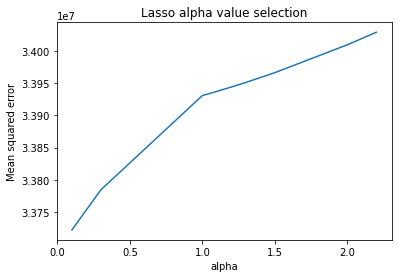

Best value of lasso alpha: 0.1
------------------------------------------



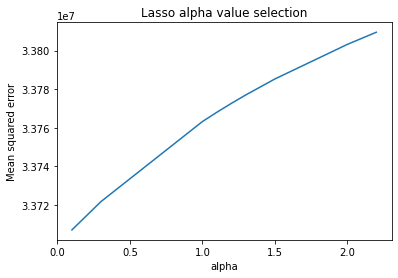

Best value of ridge alpha: 0.1
-----------------------------------------

Linear Regression:
Mean Absolute Error: 4489.81184040537
Mean Squared Error: 33699329.25709374
Root Mean Squared Error: 5805.112338025316
--------------------------------------------------------

Polynomical Regression:
Mean Absolute Error: 4365.605366185704
Mean Squared Error: 32911477.48218962
Root Mean Squared Error: 5736.8525762991
--------------------------------------------------------

Lasso with alpha =  0.1
Mean Absolute Error: 4493.519556760465
Mean Squared Error: 33722060.30884501
Root Mean Squared Error: 5807.06985568841
--------------------------------------------------------

Ridge with alpha =  0.1
Mean Absolute Error: 4491.248184920418
Mean Squared Error: 33707014.68637113
Root Mean Squared Error: 5805.774253824475
--------------------------------------------------------



In [28]:
reg_models(train_reg_X, train_reg_Y, test_reg_X, test_reg_Y)

In [29]:
def class_models(X_train, y_train, X_test, y_test):
  penalties = ['l1', 'l2']
  for p in penalties:
    log = LogisticRegression(penalty=p, random_state=0, solver='liblinear')
    log.fit(X_train, y_train)
    thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    pred_proba = log.predict_proba(X_test)
    results = [[],[],[]]
    print('Logistic Regression:')
    for i in thresholds:
      y_test_pred_thr = np.where(pred_proba[:, 1] > i, 1, 0)
      results[0].append(metrics.accuracy_score(y_test, y_test_pred_thr))
      results[1].append(metrics.precision_score(y_test, y_test_pred_thr))
      results[2].append(metrics.recall_score(y_test, y_test_pred_thr))

        
    plt.plot(thresholds, results[0], label = 'accuracy')   
    plt.plot(thresholds, results[1], label = 'precision')   
    plt.plot(thresholds, results[2], label = 'recall')
    plt.title('Threshold Selection')
    plt.xlabel('threshold')
    plt.ylabel('score')
    plt.legend()
    plt.grid()
    plt.show()
    y_pred = log.predict(X_test)
    print('Logistic Regression, regularization: ', p)
    print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))
    print('Precision: ', metrics.precision_score(y_test, y_pred))
    print('Recall: ', metrics.recall_score(y_test, y_pred))
    print('F1-score: ', metrics.f1_score(y_test, y_pred))
    print('F1-score weighted: ', metrics.f1_score(y_test, y_pred, average='weighted'))
    print('-----------------------------------\n')

Logistic Regression:


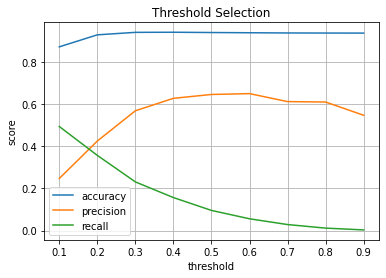

Logistic Regression, regularization:  l1
Accuracy:  0.9383446362009228
Precision:  0.6449119793902963
Recall:  0.09570536510768446
F1-score:  0.16667591410974864
F1-score weighted:  0.9163624667252146
-----------------------------------

Logistic Regression:


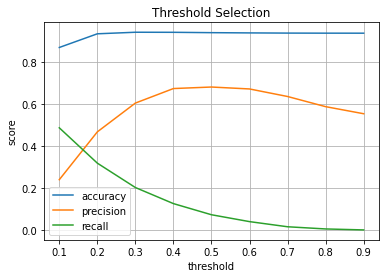

Logistic Regression, regularization:  l2
Accuracy:  0.9380860112645528
Precision:  0.68
Recall:  0.07365872307888365
F1-score:  0.13291939749338852
F1-score weighted:  0.9141022957248662
-----------------------------------



In [30]:
class_models(train_class_X, train_class_Y, test_class_X, test_class_Y)

#Deleting Outliers

In [31]:
def remove_outliers(df, columns):

  print("Old Shape: ", df.shape)

  for col in columns:
    ''' Detection '''
    # IQR
    Q1 = np.percentile(df[col], 25, interpolation = 'midpoint')
    Q3 = np.percentile(df[col], 75, interpolation = 'midpoint')
    IQR = Q3 - Q1

    # Upper bound
    df = df.loc[df[col] < (Q3 + 1.5 * IQR)]
    # Lower bound
    df = df.loc[df[col] > (Q1 - 1.5 * IQR)]

    ''' Removing the Outliers '''

  print("New Shape: ", df.shape)
  return df

In [32]:
train_class_Y.value_counts()

0    378738
1     27834
Name: stream_quality, dtype: int64

In [33]:
test_class_Y.value_counts()

0    227902
1     15694
Name: stream_quality, dtype: int64

In [34]:
train_reg_X['target'] = train_reg_Y
train_class_X['target'] = train_class_Y

In [35]:
train_reg_X = remove_outliers(train_reg_X, train_reg_X.columns)
train_class_X = remove_outliers(train_class_X, ['fps_mean', 'fps_std','rtt_mean','rtt_std'])

Old Shape:  (379021, 5)
New Shape:  (271374, 5)
Old Shape:  (406572, 11)
New Shape:  (287681, 11)


#Balancing

In [36]:
train_class_1 = train_class_X[train_class_X['target'] == 1]
size = train_class_1.shape[0]
train_class_0 = train_class_X[train_class_X['target'] == 0][:size]

In [37]:
train_class = pd.concat([train_class_0, train_class_1], axis=0)
train_class.shape

(19636, 11)

In [38]:
train_class_Y = train_class['target']
train_class_X = train_class.drop('target', axis=1)

In [39]:
train_reg_Y = train_reg_X['target']
train_reg_X = train_reg_X.drop('target', axis=1)

#Learning 2

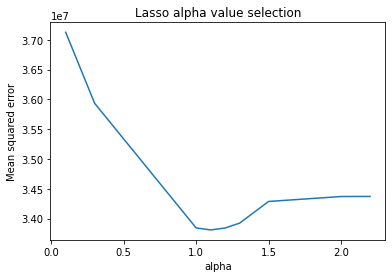

Best value of lasso alpha: 1.1
------------------------------------------



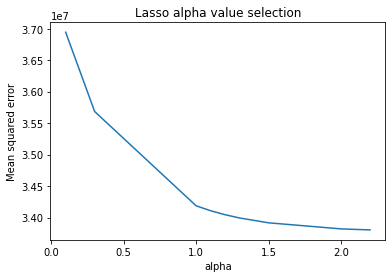

Best value of ridge alpha: 2.2
-----------------------------------------

Linear Regression:
Mean Absolute Error: 4643.642142026443
Mean Squared Error: 59262194.0082594
Root Mean Squared Error: 7698.194204374127
--------------------------------------------------------

Polynomical Regression:
Mean Absolute Error: 549002.2692558884
Mean Squared Error: 206685301716277.6
Root Mean Squared Error: 14376553.888755038
--------------------------------------------------------

Lasso with alpha =  1.1
Mean Absolute Error: 4439.841562580113
Mean Squared Error: 33810735.33771148
Root Mean Squared Error: 5814.699935311493
--------------------------------------------------------

Ridge with alpha =  2.2
Mean Absolute Error: 4450.755255057529
Mean Squared Error: 33803938.922728375
Root Mean Squared Error: 5814.115489283678
--------------------------------------------------------



In [43]:
reg_models(train_reg_X, train_reg_Y, test_reg_X, test_reg_Y)

In [44]:
train_class_Y.value_counts()

0    9818
1    9818
Name: target, dtype: int64

Logistic Regression:


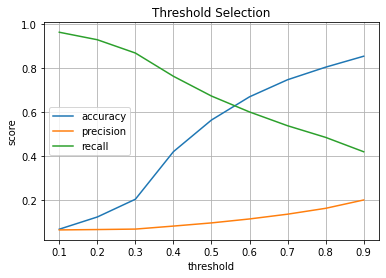

Logistic Regression, regularization:  l1
Accuracy:  0.5631989031018572
Precision:  0.09437910834861155
Recall:  0.6724225818784249
F1-score:  0.16552557074402593
F1-score weighted:  0.6694723671787447
-----------------------------------

Logistic Regression:


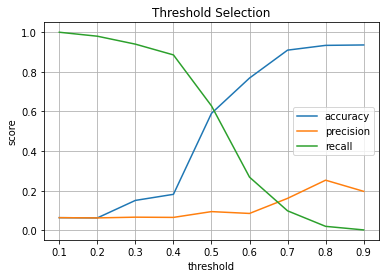

Logistic Regression, regularization:  l2
Accuracy:  0.5902847337394703
Precision:  0.0949229924581732
Recall:  0.6279469861093412
F1-score:  0.16491653767309544
F1-score weighted:  0.6922395011433096
-----------------------------------



In [45]:
class_models(train_class_X, train_class_Y, test_class_X, test_class_Y)